In [86]:
import patchseq_utils.analysis as utils
from patchseq_utils import dprime, pipelines as pipe, cluster_pairs as cp, plotting as plot
import sklearn.model_selection as ms
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Rectangle
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import plot_confusion_matrix

In [95]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/l1_load.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  human_df = human_df.assign(strict_l1= lambda df: df['layer']=='1')


<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [96]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *


## ZINB run

In [90]:
# redo NB fits?

# shiny_df = get_full_human_metadata_df()
# np.savetxt('/home/tom.chartrand/projects/human_l1/human_inh_ps_ids.txt', shiny_df['sample_id'].values, fmt="%s")

# shiny_df = get_full_mouse_metadata_df()
# np.savetxt('/home/tom.chartrand/projects/human_l1/mouse_inh_ps_ids.txt', shiny_df['sample_id'].values, fmt="%s")

# shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
# shiny_df = shiny._load_shiny_data(directory=shiny_dir)
# shiny_df = shiny_df[shiny_df['cell_subclass'].isin(['VIP', 'LAMP5/PAX6/Other'])]
# np.savetxt('/home/tom.chartrand/projects/human_l1/human_inh_facs_ids.txt', shiny_df['sample_id'].values, fmt="%s")

## Human

In [91]:
from scipy.stats import norm
np.sqrt(2) * norm.ppf(0.92)

1.9870712566946092

### ephys dprime

In [121]:
ephys_data = human_df.query("primary_ephys")
ephys_data[cluster].value_counts()

LAMP5 NMBR        71
PAX6 CDH12        31
ADARB2 MC4R       26
VIP TSPAN12       15
LAMP5 LCP2        13
LAMP5 DBP         12
SST CHRNA4         9
VIP PCDH20         9
SST BAGE2          6
PAX6 TNFAIP8L3     2
Name: t-type, dtype: int64

In [122]:
# ephys_data, clusters = subset_data(human_df, ephys_features, ephys_frac_min=0, cluster_min=10)
ephys_data = subset_data(ephys_data,  ephys_features, ephys_frac_min=0, cluster_min=5)
complete_features = subset_features(ephys_data, ephys_features, complete_frac=0.8)
features = complete_features
# features = [x for x in complete_features if x != 'fast_trough_v_adapt_ratio']

set(ephys_features).difference(complete_features)

{'3db_freq_chirp',
 'adp_v_last_rheo',
 'first_isi_inv_rheo',
 'low_freq_impedance_chirp',
 'mean_isi_rheo',
 'peak_freq_chirp',
 'peak_impedance_chirp',
 'peak_ratio_chirp',
 'phase_low_chirp',
 'phase_peak_chirp',
 'sag_tau_depol',
 'sync_freq_chirp',
 'total_inductive_phase_chirp'}

In [99]:
[x for x in complete_features if 'sag' in x]

['sag',
 'sag_peak_t',
 'sag_area',
 'sag_tau',
 'vm_for_sag',
 'sag_depol',
 'sag_peak_t_depol',
 'sag_area_depol']

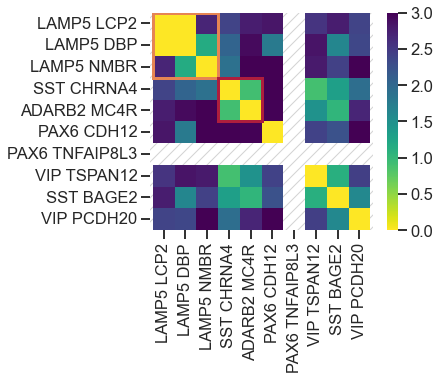

In [105]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
ephys_dprime_log, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)

plt.figure(figsize=(5,4))
cp.plot_dprime(clf, ephys_data, complete_features, cluster_list=l1_types_human)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
save_plot_multiple(figdir/"f6_ttype_dprime_ephys", ['pdf','svg'])

In [106]:
ephys_dprime_rf, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)

### Subclass dprime

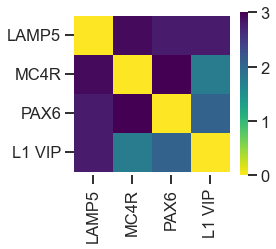

In [104]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
data = human_df.query("core_l1_type & primary_ephys")
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster='homology_type');
save_plot_multiple(figdir/"f6_dprime_human_ephys", ['pdf','svg'])

In [123]:
ephys_subclass_dprime, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, details=False,
                                                        cluster_label='homology_type')

### Morpho dprime

In [15]:
data = human_df.query('core_l1_type')
# data = human_df.query('l1_type')
features = morph_features
data = subset_data(data, features, ephys_frac_min=0, cluster_min=0)
data.homology_type.value_counts(dropna=False)

LAMP5     29
PAX6      19
MC4R      12
L1 VIP     4
Name: homology_type, dtype: int64

In [16]:
subclasses = ['LAMP5', 'MC4R', 'PAX6', 'L1 VIP']

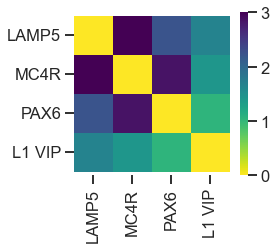

In [17]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cv=5, cluster_list=subclasses);
save_plot_multiple(figdir/"f6_dprime_human_morpho", ['pdf','svg'])

## Mouse

### ephys dprime

In [18]:
data = mouse_df.query('primary_ephys')
data = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=0,)
data[cluster].value_counts(dropna=False)

Lamp5 Plch2 Dock5        89
Lamp5 Lsp1               53
Lamp5 Ntn1 Npy2r         45
Vip Col15a1 Pde1a        26
Sncg Vip Nptx2           17
Lamp5 Fam19a1 Tmem182    15
Lamp5 Fam19a1 Pax6        6
Lamp5 Krt73               4
Name: t-type, dtype: int64

In [19]:
complete_features = subset_features(data, ephys_features, complete_frac=0.8)
features = complete_features

set(ephys_features).difference(complete_features)

{'3db_freq_chirp',
 'adp_v_last_rheo',
 'first_isi_inv_rheo',
 'ir_late_hero',
 'low_freq_impedance_chirp',
 'mean_isi_rheo',
 'peak_freq_chirp',
 'peak_impedance_chirp',
 'peak_ratio_chirp',
 'phase_low_chirp',
 'phase_peak_chirp',
 'sync_freq_chirp',
 'total_inductive_phase_chirp'}

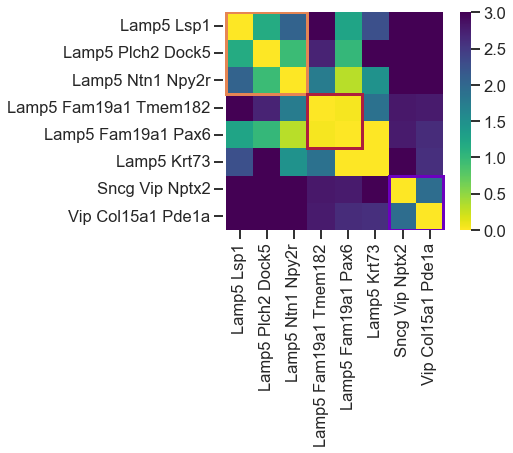

In [20]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
# data = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=0,)
# ephys_dprime_log, records = cp.pairwise_cluster_distances(clf, data, complete_features, cluster, details=False)

plt.figure(figsize=(5,4))
cp.plot_dprime(clf, data, complete_features, cluster_list=l1_types_mouse, cv=4)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((6,6), 2, 2, edgecolor=palette_subclass['L1 VIP'], **args))
save_plot_multiple(figdir/"f6_ttype_dprime_ephys_mouse",  ['pdf','svg'])

In [21]:
ephys_dprime_rf_mouse, records = cp.pairwise_cluster_distances(clf, data, complete_features, cluster, details=False)

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less

### Ephys subclass

In [118]:
data = mouse_df.query('primary_ephys')
data = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=4,)
data.homology_type.value_counts(dropna=False)

LAMP5     187
L1 VIP     43
MC4R       21
PAX6        4
Name: homology_type, dtype: int64

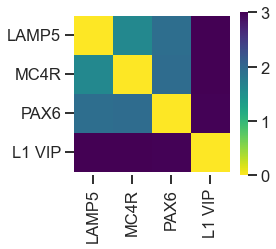

In [108]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
plt.figure(figsize=(3.5,3))
# cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cluster_list=subclasses);
cp.plot_dprime(clf, data, complete_features, cluster='homology_type', cv=5);
save_plot_multiple(figdir/"f6_dprime_mouse_ephys",  ['pdf','svg'])

In [119]:
ephys_subclass_dprime_mouse, records = cp.pairwise_cluster_distances(clf, data, complete_features, details=False,
                                                        cluster_label='homology_type', cv=4)

### Morph

In [25]:
subclasses = ['LAMP5', 'MC4R', 'PAX6', 'L1 VIP']

In [26]:
data = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
data = subset_data(data, morph_features, ephys_frac_min=0, cluster_min=4, cluster='homology_type')
data.homology_type.value_counts(dropna=False)

LAMP5     28
L1 VIP     8
MC4R       6
Name: homology_type, dtype: int64

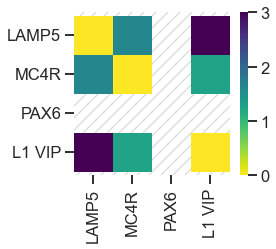

In [27]:
plt.figure(figsize=(3.5,3))
clf = RandomForestClassifier(class_weight='balanced_subsample')
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cluster_list=subclasses);
save_plot_multiple(figdir/"f6_dprime_mouse_morpho",  ['pdf','svg'])

## comparison

In [127]:
ephys_subclass_dprime_mouse

,LAMP5,MC4R,PAX6,L1 VIP
LAMP5,0.000000,1.582802,2.700966,3.710604
MC4R,1.582802,0.000000,2.204453,3.592596
PAX6,2.700966,2.204453,0.000000,3.209142
L1 VIP,3.710604,3.592596,3.209142,0.000000


<AxesSubplot:xlabel='species', ylabel='dprime'>

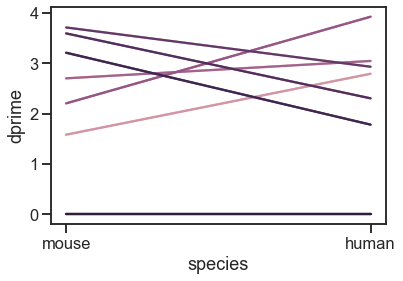

In [128]:
flatten = lambda x: x.unstack().rename('dprime').to_frame().reset_index().assign(i=lambda x: range(len(x)))
compare = pd.concat([flatten(ephys_subclass_dprime_mouse).assign(species='mouse'),
                     flatten(ephys_subclass_dprime.loc[subclasses, subclasses]).assign(species='human')], ignore_index=True)
sns.lineplot(x='species',y='dprime', hue='i',data=compare, legend=False)

## Transcriptomics

In [29]:
names_df = pd.read_csv("/home/tom.chartrand/projects/human_l1/human_MTG_cluster_conversion.csv")
full_names_update = (names_df.set_index(names_df['patchseq_cluster'])
                ['current_FACS_cluster'].to_dict())
import ateam.data.shiny as shiny

l1_types_human_ps = [
        "Inh L1-2 PAX6 CDH12",
        "Inh L1-2 PAX6 TNFAIP8L3",
        "Inh L1 SST NMBR (ADARB2+)",
        "Inh L1-2 LAMP5 DBP",
        "Inh L1-4 LAMP5 LCP2 (rosehip)",
        "Inh L1 SST CHRNA4 (ADARB2+)",
        "Inh L1-2 GAD1 MC4R (ADARB2+)",
        # "Inh L1-3 PAX6 SYT6 (Sncg)",
        "Inh L1-2 VIP TSPAN12",
        "Inh L1-2 SST BAGE2 (ADARB2+)",
        "Inh L1-2 VIP PCDH20",
]
l1_types_human_facs = [full_names_update[x] for x in l1_types_human_ps]


gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

747

### marker correlation

In [30]:
def get_group_means(shiny_dir, type_col, type_list, gene_list, ps=True):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=ps)
    if ps:
        shiny_df[type_col] = shiny_df[type_col].map(full_names_update)
    shiny_df = shiny_df[shiny_df[type_col].isin(type_list)]
    shiny_df[gene_list] = shiny_df[gene_list].transform(lambda x: np.log(1+x))
    res = shiny_df.groupby(type_col)[gene_list].agg('mean')
    return res

In [31]:
shiny_dir = shiny.shiny_directory('human')
type_col='topLeaf'
type_list = l1_types_human_facs
ps_means = get_group_means(shiny_dir, type_col, type_list, gene_list)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
type_col='cluster'
facs_means = get_group_means(shiny_dir, type_col, type_list, gene_list, ps=False)

r=0.84, p=0


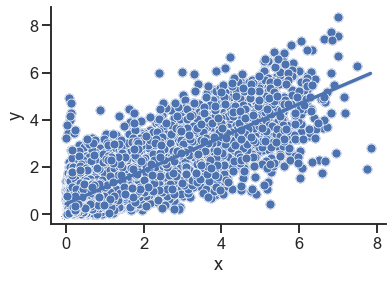

In [114]:
data = pd.DataFrame(dict(x=facs_means.values.flatten(), y=ps_means.values.flatten()))
plot.plot_corr(data=data, x="x", y='y', spearman=False)

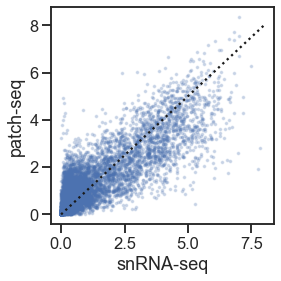

In [115]:
plt.figure(figsize=(4,4))
plt.scatter(x=facs_means.values[:], y=ps_means.values[:], alpha=0.2, s=5)

xmax = 8
plt.plot([0, xmax], [0, xmax], ':k')
plt.ylabel('patch-seq')
plt.xlabel('snRNA-seq')
save_plot_multiple(figdir/"s1_marker_corr_ps_vs_facs", ['pdf','svg'])

### dprime

In [32]:
import scipy.spatial.distance as distance
def get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, transforms=[], species='human'):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=nms_pass)
    shiny_df['t-type'] = shiny_df[type_col]
    for fcn in transforms:
        shiny_df['t-type'] = shiny_df['t-type'].map(fcn)
    if species=='human':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_human)
    if species=='mouse':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_mouse)
    # in case some requested genes are missing
    gene_list = shiny_df.columns.intersection(gene_list)
    return shiny_df, gene_list

def get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=None, normalize=False, log=False):
    if type_list is not None:
        shiny_df = shiny_df[shiny_df[type_col].isin(type_list)].copy()
    if query is not None:
        shiny_df = shiny_df.query(query)
    gene_list = shiny_df.columns.intersection(gene_list)
    data = shiny_df[gene_list].values
    # Normalization
    if normalize:
        cell_totals = data.sum(axis=1)
        avg_total = cell_totals.mean()
        data = avg_total * data / cell_totals[:, np.newaxis]
    if log:
        data = np.log(data+1)
    shiny_df[gene_list] = data
    print("using data with shape {}".format(data.shape))
    return shiny_df

def tx_dprime(df, features, cluster_label, type_list=None, n_folds=5, r=3, zero_inflated=True, **kwargs ):
    type_labels = df[cluster_label]
    data = df[features].values
    if type_list is None:
        type_list = type_labels.unique()
    # d-prime calculation
    if zero_inflated:
        dprime_results = dprime.zinb_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r, **kwargs)
    else:
        dprime_results = dprime.negative_binomial_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r, **kwargs)

    dprime_mat = distance.squareform(
        [np.abs(dprime_results[k]["dprime"]) for k in dprime_results])
    output_dprime_df = pd.DataFrame(dprime_mat, index=type_list, columns=type_list)
#     return output_dprime_df, dprime_results
    return output_dprime_df

def tx_dprime_new(df, features, cluster_label, type_list=None, n_folds=5, **kwargs):
    type_labels = df[cluster_label]
    data = df[features].values
    if type_list is None:
        type_list = type_labels.unique()
    dprime_results = dprime.zinb_dprime_fit_phi(
            data, type_list, type_labels, n_folds=n_folds,
            spaced_log_mu=spaced_log_mu, pi_lookup=fit_pi, phi_lookup=fit_phi, **kwargs)

    dprime_mat = distance.squareform(
        [np.abs(dprime_results[k]["dprime"]) for k in dprime_results])
    output_dprime_df = pd.DataFrame(dprime_mat, index=type_list, columns=type_list)
#     return output_dprime_df, dprime_results
    return output_dprime_df

## Human dprime

In [53]:
import h5py
f = h5py.File("/home/tom.chartrand/projects/human_l1/zinb_human.h5", "r")
spaced_log_mu = f['regularizations/spaced_log_mu'][...]
fit_phi = f['regularizations/phi_kr_fit'][...]
fit_pi = f['regularizations/pi_sig_fit'][...]
f.close()

In [54]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
shiny_dir = shiny.shiny_directory('human')
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, 
                     transforms=[shorten_name, names_update], species='human')
# shiny_df = shiny_df.query("contam_sum<2")
shiny_df = shiny_df.loc[human_df.query("l1_type").index]
shiny_df['t-type'].value_counts().loc[ttypes_human.categories]

LAMP5 LCP2        16
LAMP5 DBP         15
LAMP5 NMBR        82
SST CHRNA4        13
ADARB2 MC4R       33
PAX6 CDH12        44
PAX6 TNFAIP8L3     4
VIP TSPAN12       20
SST BAGE2         12
VIP PCDH20        11
Name: t-type, dtype: int64

In [55]:
data = get_gene_data(
    # shiny_df.loc[shiny_df['t-type']!='PAX6 TNFAIP8L3'], 
    shiny_df,
    gene_list, type_col='t-type', 
    query=None, type_list=ttypes_human.categories, log=True, normalize=False)

using data with shape (250, 747)


In [56]:
k = 1
ps_dprime_zinb = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k, n_folds=4)

0


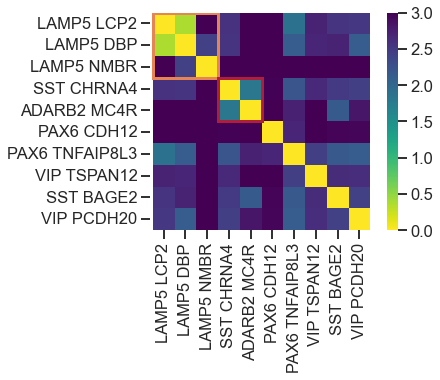

In [58]:
plt.figure(figsize=(5,4))
# sns.heatmap(ps_dprime_zinb.loc[ttypes_human.categories,ttypes_human.categories], cmap='viridis_r', vmin=0, vmax=3, cbar=True)
# plt.axis('equal')
cp.plot_dprime_data(ps_dprime_zinb, cluster_list=ttypes_human.categories)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
# ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['PAX6'], **args))
save_plot_multiple(figdir/"f6_ttype_dprime_tx", ['svg'])

### subclass

In [59]:
data = get_gene_data(shiny_df, gene_list, query="subclass!='other'", log=False, normalize=False)
subclasses = ['LAMP5', 'PAX6', 'MC4R', 'L1 VIP']

/tmp/ipykernel_28147/1799026157.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiny_df[gene_list] = data


using data with shape (227, 747)


In [60]:
k = 1

human_subclass_dprime = tx_dprime_new(data, gene_list, 'subclass', 
                                      type_list=subclasses, reg_num=k, reg_den=k)

0


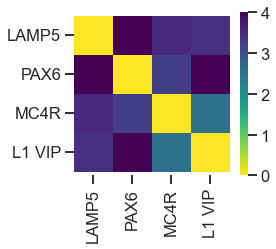

In [61]:
plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
save_plot_multiple(figdir/"f6_dprime_human_tx", ['svg'])

### FACS

In [41]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'

gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()

shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='cluster', nms_pass=False, 
                     transforms=[shorten_name], species='human')

shiny_df = shiny_df.loc[lambda df: df.layer.isin(['L1', 'L2'])]

shiny_df['t-type'].value_counts().loc[ttypes_human.categories]

LAMP5 LCP2        100
LAMP5 DBP          21
LAMP5 NMBR        272
SST CHRNA4         52
ADARB2 MC4R       101
PAX6 CDH12         85
PAX6 TNFAIP8L3     13
VIP TSPAN12        37
SST BAGE2         100
VIP PCDH20         53
Name: t-type, dtype: int64

In [42]:

slice_affected_genes  = pd.read_csv("~/work/r_patchseq/l1_manuscript/is_immune.txt", header=None)
gene_list_clean = set(gene_list).difference(slice_affected_genes[0].to_list())

In [43]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

# types = l1_types_human+["Inh L1-2 VIP LBH"]
types = l1_types_human
facs_dprime = tx_dprime(data, gene_list, type_list=types, zero_inflated=False, r=1,
                        cluster_label='t-type')

using data with shape (834, 747)
0


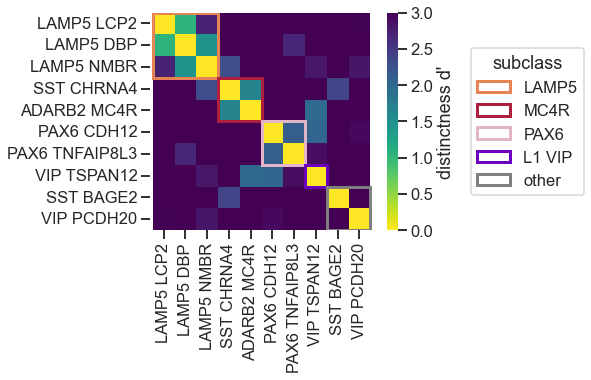

In [44]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime, cmap='viridis_r', vmin=0, vmax=3, cbar=True, cbar_kws=dict(label="distinctness d'"))
plt.axis('equal')
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
boxes = [
    ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args)),
    ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args)),
    ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['PAX6'], **args)),
    ax.add_patch(Rectangle((7,7), 1, 1, edgecolor=palette_subclass['L1 VIP'], **args)),
    ax.add_patch(Rectangle((8,8), 2, 2, edgecolor=palette_subclass['other'], **args)),
]
plt.legend(boxes, ['LAMP5', 'MC4R','PAX6','L1 VIP','other'], title='subclass',
           bbox_to_anchor=(1.4, 0.5), loc='center left')
plt.show()
save_plot_multiple(figdir/"f1_dprime", ['pdf','svg'])

In [68]:
facs_dprime

,LAMP5 LCP2,LAMP5 DBP,LAMP5 NMBR,SST CHRNA4,ADARB2 MC4R,PAX6 CDH12,PAX6 TNFAIP8L3,VIP TSPAN12,SST BAGE2,VIP PCDH20
LAMP5 LCP2,0.000000,1.056009,2.715346,3.506496,3.645211,3.604484,3.354307,3.453775,3.569595,2.986316
LAMP5 DBP,1.056009,0.000000,1.457058,3.685606,3.394164,3.760039,2.672171,2.990186,3.431830,3.529144
LAMP5 NMBR,2.715346,1.457058,0.000000,2.287498,5.041518,3.868595,3.184831,2.815423,3.007423,2.832008
SST CHRNA4,3.506496,3.685606,2.287498,0.000000,1.643301,3.453775,3.054764,3.227653,2.400529,3.115885
ADARB2 MC4R,3.645211,3.394164,5.041518,1.643301,0.000000,3.607143,3.358909,1.989518,2.997239,3.030335
PAX6 CDH12,3.604484,3.760039,3.868595,3.453775,3.607143,0.000000,2.109751,2.004154,3.552709,2.931550
PAX6 TNFAIP8L3,3.354307,2.672171,3.184831,3.054764,3.358909,2.109751,0.000000,2.904440,3.354307,3.901205
VIP TSPAN12,3.453775,2.990186,2.815423,3.227653,1.989518,2.004154,2.904440,0.000000,3.350225,3.960766
SST BAGE2,3.569595,3.431830,3.007423,2.400529,2.997239,3.552709,3.354307,3.350225,0.000000,3.011660
VIP PCDH20,2.986316,3.529144,2.832008,3.115885,3.030335,2.931550,3.901205,3.960766,3.011660,0.000000


## mouse TX

### FACS

In [45]:
shiny_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

In [46]:
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='cluster', nms_pass=False, 
                      species='mouse')
shiny_df = shiny_df.loc[lambda df: df.layer.isin(['L1', 'L2/3', 'L1-L2/3'])]

KeyboardInterrupt: 

In [231]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_mouse.categories, log=False, normalize=False)

# types = l1_types_human+["Inh L1-2 VIP LBH"]
types = l1_types_mouse
facs_dprime_mouse = tx_dprime(data, gene_list, type_list=types, zero_inflated=False, r=1,
                        cluster_label='t-type')

using data with shape (985, 4020)
0


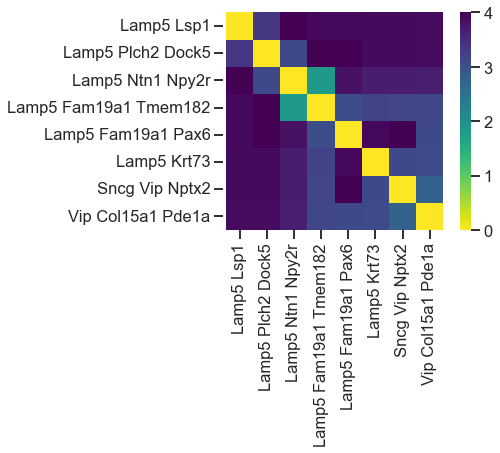

In [232]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime_mouse, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

### PS

In [62]:
import h5py
f = h5py.File("/home/tom.chartrand/projects/human_l1/zinb_mouse.h5", "r")
spaced_log_mu = f['regularizations/spaced_log_mu'][...]
fit_phi = f['regularizations/phi_kr_fit'][...]
fit_pi = f['regularizations/pi_sig_fit'][...]
f.close()

In [63]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

In [64]:
shiny_dir = shiny.shiny_directory('mouse')
type_col='topLeaf'
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col=type_col, species='mouse')

In [65]:
shiny_df = shiny_df.loc[mouse_df.index]
shiny_df = shiny_df[shiny_df['structure'].fillna('').str.contains('VIS')]


data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_mouse.categories, log=False, normalize=False)

using data with shape (272, 4020)


In [66]:
data[cluster].value_counts()

Lamp5 Plch2 Dock5        94
Lamp5 Lsp1               59
Lamp5 Ntn1 Npy2r         49
Vip Col15a1 Pde1a        26
Lamp5 Fam19a1 Tmem182    17
Sncg Vip Nptx2           17
Lamp5 Fam19a1 Pax6        6
Lamp5 Krt73               4
Name: t-type, dtype: int64

0


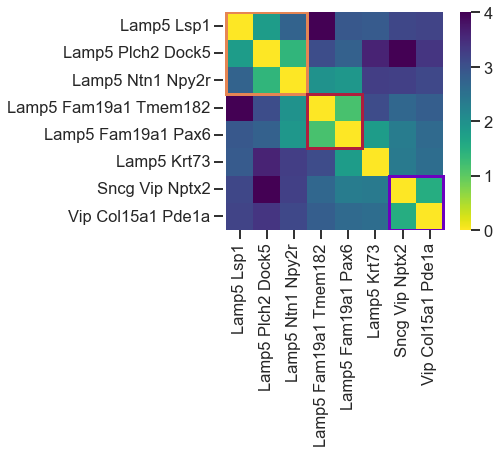

In [67]:

ps_dprime_mouse = tx_dprime(data, gene_list, type_list=l1_types_mouse, zero_inflated=False, r=1,
                        cluster_label='t-type', n_folds=4)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_mouse, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((6,6), 2, 2, edgecolor=palette_subclass['L1 VIP'], **args))
save_plot_multiple(figdir/"f6_ttype_dprime_ephys", ['svg'])

In [68]:
k = 1
mouse_subclass_dprime = tx_dprime_new(data, gene_list, 'subclass', reg_num=k, reg_den=k, n_folds=4)

0


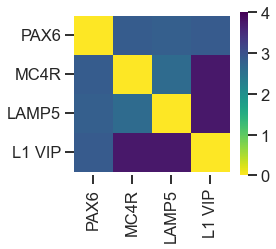

In [69]:
plt.figure(figsize=(3.5, 3))
sns.heatmap(mouse_subclass_dprime, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
save_plot_multiple(figdir/"f6_dprime_mouse_tx", ['svg'])

## cross-modality correlation

In [78]:
def get_distances(df1, df2=None, name1='1', name2='2', mapping=homology_mapping_human):
    df1 = df1.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cols = df1.columns if df2 is None else df1.columns.intersection(df2.columns)
    dflat = df1.loc[cols, cols].unstack().rename(name1).to_frame()
    if df2 is not None:
        dflat = dflat.join(df2.loc[cols, cols].unstack().rename(name2))
    dflat = dflat.reset_index().loc[lambda df: df['level_0']>df['level_1']]
    dflat['pair type'] = dflat.apply(lambda x: 'within' 
                                     if (mapping[x['level_0']] == mapping[x['level_1']]) and (mapping[x['level_0']]!='other') 
                                 else 'between', axis=1)
    return dflat.set_index(['level_0', 'level_1'])

### Mouse tx-ephys

r=0.81, p=8e-06


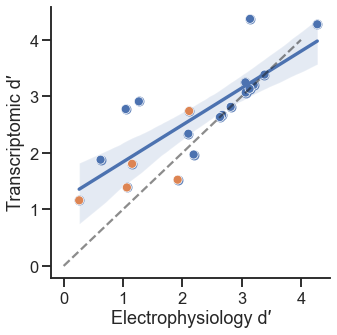

In [85]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf_mouse, ps_dprime_mouse, x, y, mapping=homology_mapping_mouse)

fig, ax = plt.subplots(figsize=(5,5))
plot.plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
# plt.axis('equal')
# plt.xlim(0,4)
# plt.ylim(0,4)

### Human tx-ephys

r=0.59, p=0.00016


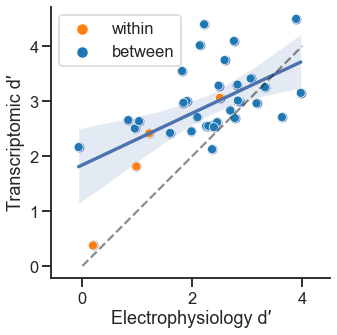

In [80]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'

dflat = get_distances(ephys_dprime_rf, ps_dprime_zinb, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot.plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair type', legend=True, ax=ax, 
               smooth=True, palette={'within':'tab:orange','between':'tab:blue'})
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
plt.axis('equal')
plt.legend()
save_plot_multiple(figdir/"f6_dprime_corr", ['svg'])

In [81]:
y = 'FACS d′'
x = 'PS d′'
dflat = get_distances(ps_dprime_zinb, facs_dprime, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot.plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4])
plt.axis('equal')
# plt.xlim(0,4)
# plt.ylim(0,4)

NameError: name 'facs_dprime' is not defined

In [219]:
from scipy.stats import spearmanr
import seaborn as sns

def dprime_similarity(df1, df2):
    cols = df1.columns.intersection(df2.columns)
    x1 = distance.squareform(df1.loc[cols, cols].values)
    x2 = distance.squareform(df2.loc[cols, cols].values)
    r, p = pearsonr(x1, x2)
    return r

def dprime_distplot(dprime_list, names, clusters=None):
    clusters = clusters or dprime_list[0].columns
    if clusters=='all':
        dist_vals = [distance.squareform(df.values) for df in dprime_list]
    else:
        dist_vals = [distance.squareform(df.loc[clusters, clusters].values) for df in dprime_list]
    df = pd.DataFrame(dist_vals, index=names)
    all_dprimes = df.T.melt(var_name='dataset', value_name='dprime')

    # sns.displot(data=all_dprimes, x='dprime', hue='dataset', kind='kde')
    sns.violinplot(data=all_dprimes, x='dprime', y='dataset', cut=0)

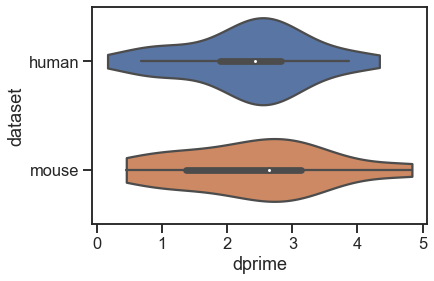

In [220]:
dprime_list = [ephys_dprime_rf, ephys_dprime_rf_mouse,  ]
names = ['human','mouse']
dprime_distplot(dprime_list, names, clusters='all')

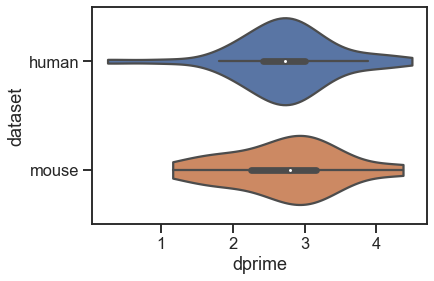

In [228]:
dprime_list = [ps_dprime_zinb, ps_dprime_mouse,  ]
names = ['human','mouse']
dprime_distplot(dprime_list, names, clusters='all')

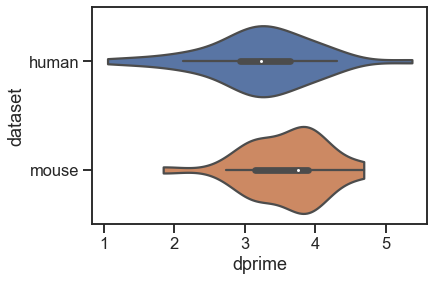

In [233]:
dprime_list = [facs_dprime, facs_dprime_mouse,  ]
names = ['human','mouse']
dprime_distplot(dprime_list, names, clusters='all')

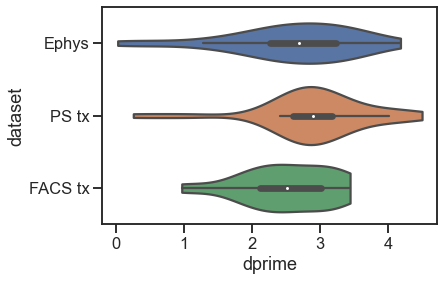

In [168]:
dprime_list = [ephys_dprime_rf, ps_dprime_zinb, facs_dprime, ]
names = ['Ephys', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)